정답률을 높이고자 '데이타 수량 늘리기'를 자주 사용한다.

사진을 회전하거나 반전하는 것이다.

왜냐하면 사람이 보기에 같은 그림이라도 컴퓨터는 사진을 조금만 회전해도 다른 이미지로 인식한다.

## 그러나 이번 이미지로는 정답률이 현저히 더 낮게 나온다.
다른 그림으로 다시 확인하길

In [1]:
# 동일한 모델

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import RMSprop

# CNN 모델 정의하기
def def_model(in_shape, nb_classes):
    model = Sequential()
    model.add(Conv2D(32,
              kernel_size=(3, 3),
              activation='relu',
              input_shape=in_shape))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(nb_classes, activation='softmax'))
    return model

# 컴파일하고 모델 반환하기
def get_model(in_shape, nb_classes):
    model = def_model(in_shape, nb_classes)
    model.compile(
        loss='categorical_crossentropy',
        optimizer=RMSprop(),
        metrics=['accuracy'])
    return model



cnn_model.py 파일에 함수를 선언하고 호출하는 방식으로 진행

In [2]:
import cnn_model

from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import cv2


# 입력과 출력 지정하기
im_rows = 32 # 이미지의 높이
im_cols = 32 # 이미지의 너비
im_color = 3 # 이미지의 색공간
in_shape = (im_rows, im_cols, im_color)
nb_classes = 5

# 사진 데이터 읽어 들이기
photos = np.load('image/photos.npz')
x = photos['x']
y = photos['y']

# 읽어들인 데이터를 3차원 배열로 변환하기
x = x.reshape(-1, im_rows, im_cols, im_color)
x = x.astype('float32') / 255
# 레이블 데이터를 One-hot 형식으로 변환하기
y = to_categorical(y.astype('int32'), nb_classes)

# 학습 전용과 테스트 전용으로 구분하기
x_train, x_test, y_train, y_test = train_test_split(
    x, y, train_size=0.8)

# 학습 전용 데이터 수 늘리기 --- (*1)
x_new = []
y_new = []
for i, xi in enumerate(x_train):
    yi = y_train[i]
    for ang in range(-30, 30, 5):
        # 회전 시키기 --- (*2)
        center = (16, 16) # 회전 중심
        mtx = cv2.getRotationMatrix2D(center, ang, 1.0)
        xi2 = cv2.warpAffine(xi, mtx, (32, 32))
        x_new.append(xi2)
        y_new.append(yi)
        # 좌우 반전 --- (*3)
        xi3 = cv2.flip(xi2, 1)
        x_new.append(xi3)
        y_new.append(yi)

# 이미지를 늘린 데이터를 학습 데이터로 사용하기
print('수량을 늘리기 전=', len(y_train))
x_train = np.array(x_new)
y_train = np.array(y_new)
print('수량을 늘린 후=', len(y_train))


수량을 늘리기 전= 903
수량을 늘린 후= 21672


In [3]:

# CNN 모델 만들기 --- (*6)
model = cnn_model.get_model(in_shape, nb_classes)

# 학습 실행하기 --- (*8) 시간소요 많음 ( 30분이상 )
hist = model.fit(x_train, y_train,
          batch_size=64,
          epochs=50,
          verbose=1,
          validation_data=(x_test, y_test))

# 모델 평가하기 --- (*9)
score = model.evaluate(x_test, y_test, verbose=1)
print('정답률=', score[1], 'loss=', score[0])



Epoch 1/50
339/339 [==============================] - 47s 137ms/step - loss: 1.3868 - accuracy: 0.4162 - val_loss: 1.0761 - val_accuracy: 0.5088
Epoch 2/50
339/339 [==============================] - 47s 140ms/step - loss: 0.8646 - accuracy: 0.6559 - val_loss: 1.0392 - val_accuracy: 0.6283
Epoch 3/50
339/339 [==============================] - 55s 163ms/step - loss: 0.5947 - accuracy: 0.7643 - val_loss: 1.1565 - val_accuracy: 0.6195
Epoch 4/50
339/339 [==============================] - 52s 155ms/step - loss: 0.3956 - accuracy: 0.8521 - val_loss: 1.5413 - val_accuracy: 0.5973
Epoch 5/50
339/339 [==============================] - 49s 146ms/step - loss: 0.2635 - accuracy: 0.9039 - val_loss: 1.9148 - val_accuracy: 0.5664
Epoch 6/50
339/339 [==============================] - 54s 159ms/step - loss: 0.2038 - accuracy: 0.9308 - val_loss: 1.8759 - val_accuracy: 0.6150
Epoch 7/50
339/339 [==============================] - 51s 151ms/step - loss: 0.1667 - accuracy: 0.9405 - val_loss: 2.2462 - val_ac

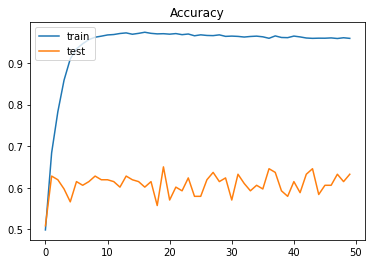

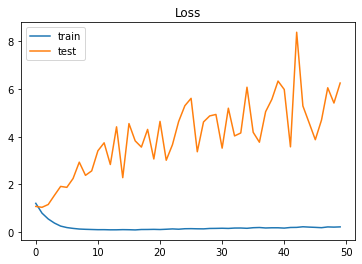

In [4]:
# 학습 상태를 그래프로 그리기 --- (*10)
# 정답률 추이를 그래프로 그리기
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Accuracy')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# 손실 추이를 그래프로 그리기
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

model.save_weights('./image/photos-model.hdf5')
